# Language detection using neural networks

### Imports

In [1]:
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

### Check GPU availability

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Data loading

In [3]:
df = pd.read_csv("data/sentences_10k.csv", delimiter=",", encoding='utf8', index_col=0)
df.head()

,id,lan_code,sentence
0,1,cmn,我們試試看！
1,2,cmn,我该去睡觉了。
2,3,cmn,你在干什麼啊？
3,4,cmn,這是什麼啊？
4,5,cmn,今天是６月１８号，也是Muiriel的生日！


In [4]:
langs = list(df["lan_code"].unique())

In [5]:
lang_to_num = {lan: i for i, lan in enumerate(langs)}
print(lang_to_num)

num_to_lang = {i: lan for lan, i in lang_to_num.items()}
print(num_to_lang)

{'cmn': 0, 'deu': 1, 'rus': 2, 'fra': 3, 'eng': 4, 'jpn': 5, 'spa': 6, 'ita': 7, 'vie': 8, 'nld': 9, 'epo': 10, 'por': 11, 'tur': 12, 'heb': 13, 'hun': 14, 'ell': 15, 'ind': 16, 'ara': 17, 'fin': 18, 'bul': 19, 'swe': 20, 'ukr': 21, 'bel': 22, 'ces': 23, 'nob': 24, 'pol': 25, 'lat': 26, 'isl': 27, 'ron': 28, 'tat': 29, 'srp': 30, 'dan': 31, 'pes': 32, 'slk': 33, 'tgl': 34, 'hin': 35, 'lit': 36, 'mkd': 37, 'jbo': 38, 'tok': 39, 'ina': 40, 'nds': 41, 'tlh': 42, 'kab': 43, 'ber': 44, 'mar': 45, 'ckb': 46, 'lfn': 47}
{0: 'cmn', 1: 'deu', 2: 'rus', 3: 'fra', 4: 'eng', 5: 'jpn', 6: 'spa', 7: 'ita', 8: 'vie', 9: 'nld', 10: 'epo', 11: 'por', 12: 'tur', 13: 'heb', 14: 'hun', 15: 'ell', 16: 'ind', 17: 'ara', 18: 'fin', 19: 'bul', 20: 'swe', 21: 'ukr', 22: 'bel', 23: 'ces', 24: 'nob', 25: 'pol', 26: 'lat', 27: 'isl', 28: 'ron', 29: 'tat', 30: 'srp', 31: 'dan', 32: 'pes', 33: 'slk', 34: 'tgl', 35: 'hin', 36: 'lit', 37: 'mkd', 38: 'jbo', 39: 'tok', 40: 'ina', 41: 'nds', 42: 'tlh', 43: 'kab', 44: 'b

In [6]:
df["lang_num"] = df["lan_code"].map(lang_to_num).astype(int)
lang_count = len(df['lang_num'].unique())

In [7]:
mean_sentence_len = df["sentence"].str.len().mean()
median_sentence_len = df["sentence"].str.len().median()

print(f"Mean length of sentence: {mean_sentence_len}")
print(f"Median length of sentence: {median_sentence_len}")

Mean length of sentence: 35.63898586965506
Median length of sentence: 31.0


In [8]:
input_length = int(np.floor(max(mean_sentence_len, median_sentence_len)))
print(f"Input length: {input_length}")

Input length: 35


In [9]:
def sentence_to_unicode_list(sentence):
    max_len = input_length
    unicode_list = [ord(i) for i in sentence]
    
    if len(unicode_list) >= max_len:
        unicode_list = unicode_list[:max_len]
    else:
        len_diff = max_len - len(unicode_list)
        unicode_list.extend([0 for _ in range(len_diff)])
    
    return unicode_list

def set_labels(lang):
    labels = [0 for _ in range(lang_count)]
    labels[lang] = 1
    return labels

In [10]:
df['unicode'] = df['sentence'].apply(sentence_to_unicode_list)
df['labels'] = df['lang_num'].apply(set_labels)

In [11]:
df.dropna()
df.sample(10)

,id,lan_code,sentence,lang_num,unicode,labels
8367531,8796801,ber,Skura d Nuja ddant seg Temdint n Zzayer.,44,"[83, 107, 117, 114, 97, 32, 100, 32, 78, 117, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
706483,740165,deu,Am nächsten Tag hatten wir alle einen schreckl...,1,"[65, 109, 32, 110, 228, 99, 104, 115, 116, 101...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8711582,9145864,ckb,مامزەکە ڕاوکرا.,46,"[1605, 1575, 1605, 1586, 1749, 1705, 1749, 32,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6024278,6403052,tur,Bu kaç ay önce oldu?,12,"[66, 117, 32, 107, 97, 231, 32, 97, 121, 32, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
4900530,5229659,rus,"Ты думаешь, Том готов?",2,"[1058, 1099, 32, 1076, 1091, 1084, 1072, 1077,...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1820924,1926404,eng,"Normally, which discussion forums do French pe...",4,"[78, 111, 114, 109, 97, 108, 108, 121, 44, 32,...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7997302,8414657,eng,They were Muslim.,4,"[84, 104, 101, 121, 32, 119, 101, 114, 101, 32...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1181605,1245604,epo,"Ĉi tiu homo estas monstro, vera kovaĵo de la i...",10,"[264, 105, 32, 116, 105, 117, 32, 104, 111, 10...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
9264785,9708848,kab,Ahat Tom yezmer ad kent-t-id yaɣ.,43,"[65, 104, 97, 116, 32, 84, 111, 109, 32, 121, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7929025,8344684,kab,D aǧǧal yesεan tlata n yigerdan iwumi s-ilaq a...,43,"[68, 32, 97, 487, 487, 97, 108, 32, 121, 101, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [12]:
df_numpy = df.to_numpy()

### Dense net

In [13]:
x = np.array(list(df_numpy[:, -2])[:-1])
y = np.array(list(df_numpy[:, -1])[:-1])

print(f"x_shape: {x.shape}")
print(f"y_shape: {y.shape}")

x_shape: (10041509, 35)
y_shape: (10041509, 48)


In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True)

In [15]:
model = models.Sequential()

model.add(layers.Dense(128, activation='relu', kernel_regularizer='l1_l2', input_shape=(input_length,)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu', kernel_regularizer='l1_l2'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu', kernel_regularizer='l1_l2'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1024, activation='relu', kernel_regularizer='l1_l2'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1024, activation='relu', kernel_regularizer='l1_l2'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512, activation='relu', kernel_regularizer='l1_l2'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(lang_count, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               4608      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1024)              5

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.CategoricalCrossentropy()

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [17]:
batch_size = 1024
epochs = 30

hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/30
6865/6865 [==============================] - 55s 8ms/step - loss: 22.6692 - accuracy: 0.2661 - val_loss: 5.0387 - val_accuracy: 0.2851
Epoch 2/30
6865/6865 [==============================] - 52s 8ms/step - loss: 5.1054 - accuracy: 0.2768 - val_loss: 5.0526 - val_accuracy: 0.2877
Epoch 3/30
6865/6865 [==============================] - 52s 8ms/step - loss: 5.0925 - accuracy: 0.2796 - val_loss: 5.0266 - val_accuracy: 0.2931
Epoch 4/30
6865/6865 [==============================] - 54s 8ms/step - loss: 5.0740 - accuracy: 0.2879 - val_loss: 5.0400 - val_accuracy: 0.2944
Epoch 5/30
6865/6865 [==============================] - 55s 8ms/step - loss: 5.0584 - accuracy: 0.2994 - val_loss: 5.0535 - val_accuracy: 0.2938
Epoch 6/30
6865/6865 [==============================] - 52s 8ms/step - loss: 5.0485 - accuracy: 0.3055 - val_loss: 5.0634 - val_accuracy: 0.2935
Epoch 7/30
6865/6865 [==============================] - 52s 8ms/step - loss: 5.0361 - accuracy: 0.3110 - val_loss: 5.0339 - val_a

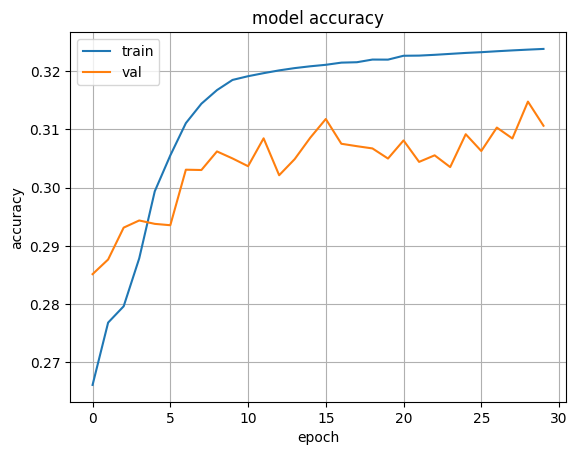

In [18]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

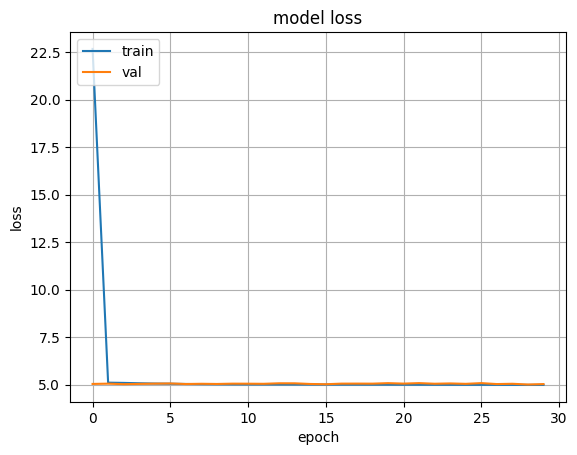

In [19]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [20]:
save_path = 'models/'
model.save_weights(save_path + 'dense_network.h5')

### Conv1D net

In [21]:
model_conv = models.Sequential()

model_conv.add(layers.Conv1D(32, 1, activation='relu', kernel_regularizer='l1_l2', input_shape=(input_length, 1)))
model_conv.add(layers.Dropout(0.1))
model_conv.add(layers.Conv1D(64, 1, activation='relu', kernel_regularizer='l1_l2'))
model_conv.add(layers.Dropout(0.15))
model_conv.add(layers.Conv1D(128, 1, activation='relu', kernel_regularizer='l1_l2'))
model_conv.add(layers.Dropout(0.2))
model_conv.add(layers.Conv1D(128, 1, activation='relu', kernel_regularizer='l1_l2'))
model_conv.add(layers.Dropout(0.25))
model_conv.add(layers.Conv1D(256, 1, activation='relu', kernel_regularizer='l1_l2'))
model_conv.add(layers.Dropout(0.3))
model_conv.add(layers.Conv1D(512, 1, activation='relu', kernel_regularizer='l1_l2'))
model_conv.add(layers.Dropout(0.3))
model_conv.add(layers.Flatten())
model_conv.add(layers.Dense(1024, activation='relu', kernel_regularizer='l1_l2'))
model_conv.add(layers.Dropout(0.3))
model_conv.add(layers.Dense(lang_count, activation='softmax'))

model_conv.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 35, 32)            64        
                                                                 
 dropout_6 (Dropout)         (None, 35, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 35, 64)            2112      
                                                                 
 dropout_7 (Dropout)         (None, 35, 64)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 35, 128)           8320      
                                                                 
 dropout_8 (Dropout)         (None, 35, 128)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 35, 128)          

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.CategoricalCrossentropy()

model_conv.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [23]:
x_conv = np.expand_dims(np.array(list(df_numpy[:, -2])[:-1]), axis=2)
y_conv = np.array(list(df_numpy[:, -1])[:-1])

print(f"x_shape: {x_conv.shape}")
print(f"y_shape: {y_conv.shape}")

x_shape: (10041509, 35, 1)
y_shape: (10041509, 48)


In [24]:
x_train_conv, x_test_conv, y_train_conv, y_test_conv = train_test_split(x, y, test_size=0.3, shuffle=True)

In [25]:
batch_size_conv = 1024
epochs_conv = 30

hist_conv = model_conv.fit(x_train_conv, y_train_conv, batch_size=batch_size_conv, epochs=epochs_conv, validation_data=(x_test_conv, y_test_conv))

Epoch 1/30
6865/6865 [==============================] - 452s 65ms/step - loss: 33.1001 - accuracy: 0.3076 - val_loss: 22.3128 - val_accuracy: 0.3325
Epoch 2/30
6865/6865 [==============================] - 446s 65ms/step - loss: 22.6093 - accuracy: 0.3394 - val_loss: 22.6897 - val_accuracy: 0.3559
Epoch 3/30
6865/6865 [==============================] - 445s 65ms/step - loss: 22.8927 - accuracy: 0.3474 - val_loss: 22.8416 - val_accuracy: 0.3551
Epoch 4/30
6865/6865 [==============================] - 445s 65ms/step - loss: 23.0086 - accuracy: 0.3510 - val_loss: 23.0118 - val_accuracy: 0.3607
Epoch 5/30
6865/6865 [==============================] - 446s 65ms/step - loss: 23.0557 - accuracy: 0.3525 - val_loss: 23.0029 - val_accuracy: 0.3612
Epoch 6/30
6865/6865 [==============================] - 445s 65ms/step - loss: 23.0932 - accuracy: 0.3537 - val_loss: 22.9843 - val_accuracy: 0.3692
Epoch 7/30
6865/6865 [==============================] - 445s 65ms/step - loss: 23.1290 - accuracy: 0.3547 

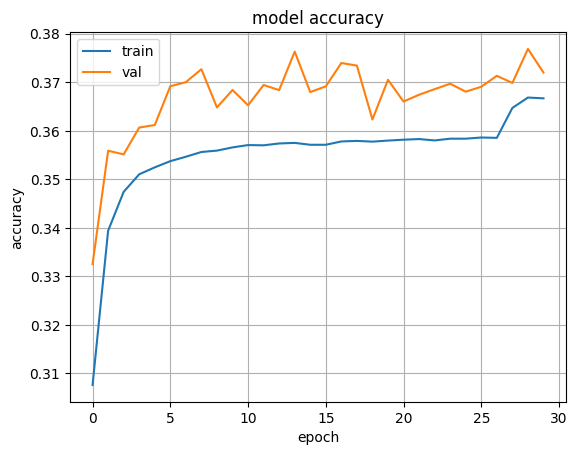

In [26]:
plt.plot(hist_conv.history['accuracy'])
plt.plot(hist_conv.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

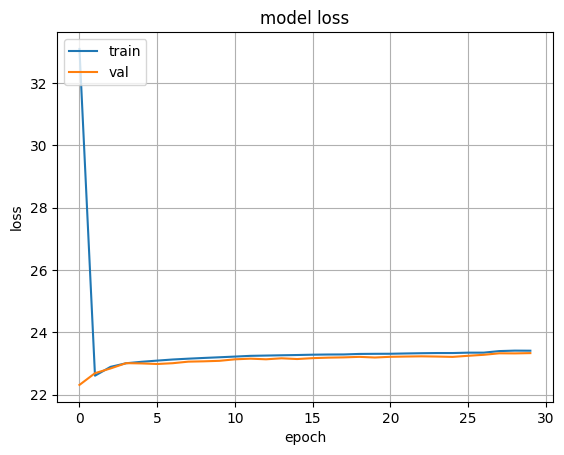

In [27]:
plt.plot(hist_conv.history['loss'])
plt.plot(hist_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [28]:
save_path = 'models/'
model_conv.save_weights(save_path + 'conv1d_network.h5')

### LSTM network

In [29]:
x_rec = np.expand_dims(np.array(list(df_numpy[:, -2])[:-1]), axis=2)
y_rec = np.array(list(df_numpy[:, -1])[:-1])

print(f"x_shape: {x_rec.shape}")
print(f"y_shape: {y_rec.shape}")

x_shape: (10041509, 35, 1)
y_shape: (10041509, 48)


In [30]:
x_train_rec, x_test_rec, y_train_rec, y_test_rec = train_test_split(x_rec, y_rec, test_size=0.3, shuffle=True)

In [31]:
model_rec = models.Sequential()

model_rec.add(layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(128, return_sequences=True), input_shape=(input_length, 1)))
model_rec.add(layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(128)))
model_rec.add(layers.Dense(lang_count, activation='softmax'))

model_rec.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 35, 256)          134144    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              395264    
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 48)                12336     
                                                                 
Total params: 541,744
Trainable params: 541,744
Non-trainable params: 0
_________________________________________________________________


In [32]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.CategoricalCrossentropy()

model_rec.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [33]:
batch_size = 1024
epochs = 15

hist_rec = model_rec.fit(x_train_rec, y_train_rec, batch_size=batch_size, epochs=epochs, validation_data=(x_test_rec, y_test_rec))

Epoch 1/15
6865/6865 [==============================] - 792s 115ms/step - loss: 0.8965 - accuracy: 0.7217 - val_loss: 0.5088 - val_accuracy: 0.8358
Epoch 2/15
6865/6865 [==============================] - 789s 115ms/step - loss: 0.4163 - accuracy: 0.8628 - val_loss: 0.3414 - val_accuracy: 0.8847
Epoch 3/15
6865/6865 [==============================] - 788s 115ms/step - loss: 0.3239 - accuracy: 0.8908 - val_loss: 0.3033 - val_accuracy: 0.8967
Epoch 4/15
6865/6865 [==============================] - 789s 115ms/step - loss: 0.2818 - accuracy: 0.9036 - val_loss: 0.2744 - val_accuracy: 0.9052
Epoch 5/15
6865/6865 [==============================] - 788s 115ms/step - loss: 0.2663 - accuracy: 0.9088 - val_loss: 0.2515 - val_accuracy: 0.9129
Epoch 6/15
6865/6865 [==============================] - 789s 115ms/step - loss: 0.2446 - accuracy: 0.9156 - val_loss: 0.2480 - val_accuracy: 0.9156
Epoch 7/15
6865/6865 [==============================] - 789s 115ms/step - loss: 0.2347 - accuracy: 0.9188 - val_

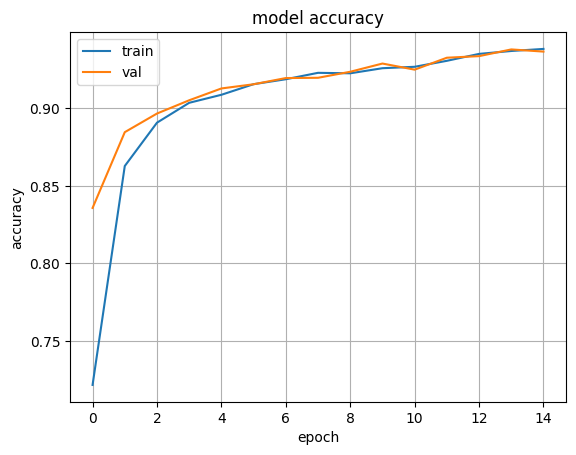

In [34]:
plt.plot(hist_rec.history['accuracy'])
plt.plot(hist_rec.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

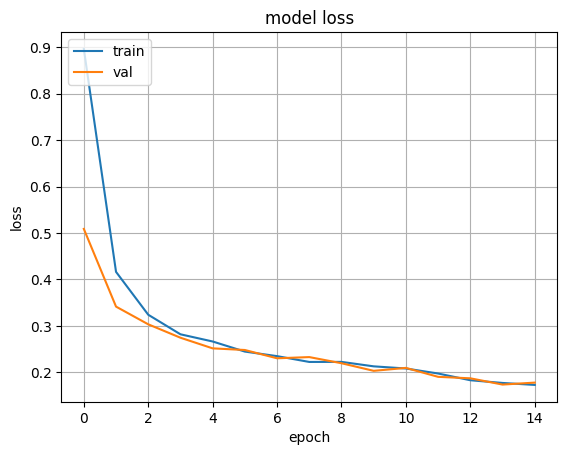

In [35]:
plt.plot(hist_rec.history['loss'])
plt.plot(hist_rec.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [36]:
save_path = 'models/'
model_rec.save_weights(save_path + 'lstm_network.h5')

### Custom dense with pairs and triplets input

In [37]:
def create_tokenizer(x):
    dictionary = dict()
    token = 1
    
    for i in range(x.shape[0]):
        symbol_list = x[i]
        
        for idx in range(len(symbol_list)):
            key = tuple([symbol_list[idx], 0, 0])
            
            if key not in dictionary:
                dictionary[key] = token
                token += 1
            
        for idx in range(len(symbol_list) - 1):
            key = tuple([symbol_list[idx], symbol_list[idx+1], 0])
            
            if key not in dictionary:
                dictionary[key] = token
                token += 1
            
        for idx in range(len(symbol_list) - 2):
            key = tuple([symbol_list[idx], symbol_list[idx+1], symbol_list[idx+2]])
            
            if key not in dictionary:
                dictionary[key] = token
                token += 1
        
    return dictionary

In [38]:
tokenizer = create_tokenizer(x)

In [39]:
# zero masking
tokenizer[tuple([0, 0, 0])] = 0

In [40]:
tokenizer_len = len(tokenizer.keys())
print(f"tokenizer_len: {tokenizer_len}")

tokenizer_len: 1411349


In [41]:
def prepare_input(symbols_list):
    result = []
    
    for symbol in symbols_list:
        result.append(tokenizer[tuple([symbol, 0, 0])])
        
    for idx in range(len(symbols_list) - 1):
        result.append(tokenizer[tuple([symbols_list[idx], symbols_list[idx+1], 0])])
        
    for idx in range(len(symbols_list) - 2):
        result.append(tokenizer[tuple([symbols_list[idx], symbols_list[idx+1], symbols_list[idx+2]])])
        
    return result

In [42]:
x_custom = np.array([prepare_input(x[i]) for i in range(x.shape[0])])
y_custom = y

print(f"x_shape: {x_custom.shape}")
print(f"y_shape: {y_custom.shape}")

x_shape: (10041509, 102)
y_shape: (10041509, 48)


In [43]:
input_length_custom = x_custom.shape[1]
print(f"input_length_custom: {input_length_custom}")

input_length_custom: 102


In [44]:
x_train_custom, x_test_custom, y_train_custom, y_test_custom = train_test_split(x_custom, y_custom, test_size=0.3, shuffle=True)

In [45]:
x_train_custom[3453]

array([ 23587,   1181,   3440,   3437,   3439,   3445,   1888,   1181,
        23263,  23262,   3448,   1181,  23373,  23262,   3448,   1181,
         3441,  23321,   3444,  23382,   3448,   1181,   3445,   3436,
         3449,  23266,   1181,   3437,   3444,   3435,   3448,   3438,
         3439,   3440,  23265,  23588,  23510,   3463,  23511,  24044,
        24723,   1895,  23275,  23276,  23277,  23355,  23374,  23375,
        23277,  23355,   3458,  23997,  23451,  23384,  23385,  23355,
        23589,  23540,  24217,  23361,  23284,  23487,  23323,  24144,
        23622,   3476,   3455,   3456,  24724,  23784,  23518,  23519,
        24937,  24728,  24729,  23523,  23300,  23301,  23364,  23377,
        23378,  23379,  23364,  23802,  24006,  24007,  24008,  23397,
        23772,  24260,  23602,  24225,  24392,  24492,  23884,  23499,
        24830,  24831,  25842,  23339,   3487, 630104])

In [46]:
our_model = models.Sequential()

# our_model.add(layers.Embedding(tokenizer_len, 8, input_length=input_length_custom, mask_zero=True, embeddings_regularizer='l1_l2'))
# our_model.add(layers.Flatten())
# our_model.add(layers.Dense(1024, activation='relu', kernel_regularizer='l1_l2'))
# our_model.add(layers.Dropout(0.2))
our_model.add(layers.Dense(256, activation='relu', kernel_regularizer='l1_l2', input_shape=(input_length_custom,)))
our_model.add(layers.Dropout(0.2))
our_model.add(layers.Dense(512, activation='relu', kernel_regularizer='l1_l2'))
our_model.add(layers.Dropout(0.3))
our_model.add(layers.Dense(1024, activation='relu', kernel_regularizer='l1_l2'))
our_model.add(layers.Dropout(0.3))
our_model.add(layers.Dense(2048, activation='relu', kernel_regularizer='l1_l2'))
our_model.add(layers.Dropout(0.3))
our_model.add(layers.Dense(256, activation='relu', kernel_regularizer='l1_l2'))
our_model.add(layers.Dropout(0.3))
our_model.add(layers.Dense(lang_count, activation='softmax'))

our_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 256)               26368     
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 512)               131584    
                                                                 
 dropout_14 (Dropout)        (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 1024)              525312    
                                                                 
 dropout_15 (Dropout)        (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 2048)             

In [47]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.CategoricalCrossentropy()

our_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [48]:
batch_size = 1024
epochs = 30

hist_our = our_model.fit(x_train_custom, y_train_custom, batch_size=batch_size, epochs=epochs, validation_data=(x_test_custom, y_test_custom))

Epoch 1/30
6865/6865 [==============================] - 63s 9ms/step - loss: 411.1356 - accuracy: 0.1579 - val_loss: 30.7530 - val_accuracy: 0.1582
Epoch 2/30
6865/6865 [==============================] - 62s 9ms/step - loss: 7.8954 - accuracy: 0.2917 - val_loss: 5.2828 - val_accuracy: 0.3626
Epoch 3/30
6865/6865 [==============================] - 62s 9ms/step - loss: 5.8343 - accuracy: 0.3343 - val_loss: 5.8773 - val_accuracy: 0.3716
Epoch 4/30
6865/6865 [==============================] - 62s 9ms/step - loss: 6.0358 - accuracy: 0.3443 - val_loss: 5.9315 - val_accuracy: 0.3674
Epoch 5/30
6865/6865 [==============================] - 62s 9ms/step - loss: 6.0710 - accuracy: 0.3460 - val_loss: 5.9614 - val_accuracy: 0.3650
Epoch 6/30
6865/6865 [==============================] - 62s 9ms/step - loss: 6.0866 - accuracy: 0.3459 - val_loss: 5.9460 - val_accuracy: 0.3746
Epoch 7/30
6865/6865 [==============================] - 62s 9ms/step - loss: 6.0943 - accuracy: 0.3456 - val_loss: 6.0311 - val

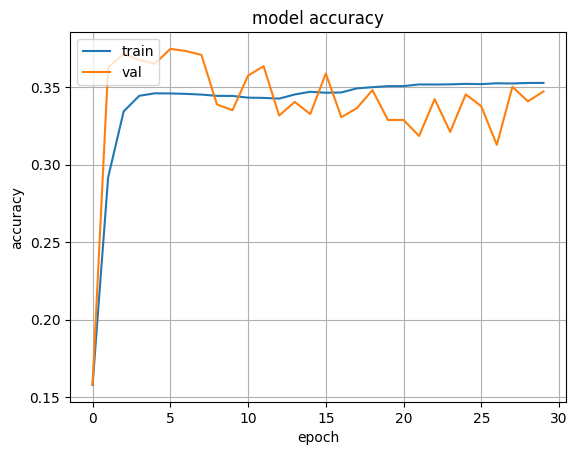

In [49]:
plt.plot(hist_our.history['accuracy'])
plt.plot(hist_our.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

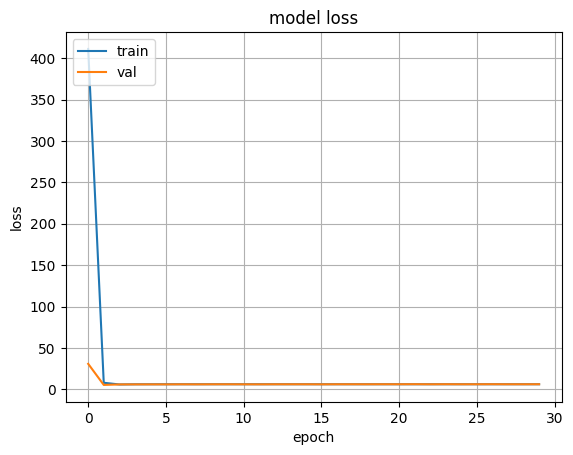

In [50]:
plt.plot(hist_our.history['loss'])
plt.plot(hist_our.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [51]:
save_path = 'models/'
our_model.save_weights(save_path + 'custom_network.h5')

### With custom embedding

In [60]:
embedding_model = models.Sequential()

embedding_model.add(layers.Embedding(tokenizer_len, 8, input_length=input_length_custom, mask_zero=True)) # embeddings_regularizer='l1_l2'
embedding_model.add(layers.Flatten())
embedding_model.add(layers.Dense(1024, activation='relu', kernel_regularizer='l1_l2'))
embedding_model.add(layers.Dropout(0.2))
embedding_model.add(layers.Dense(1024, activation='relu', kernel_regularizer='l1_l2'))
embedding_model.add(layers.Dropout(0.3))
embedding_model.add(layers.Dense(lang_count, activation='softmax'))

embedding_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 102, 8)            11290792  
                                                                 
 flatten_5 (Flatten)         (None, 816)               0         
                                                                 
 dense_32 (Dense)            (None, 1024)              836608    
                                                                 
 dropout_30 (Dropout)        (None, 1024)              0         
                                                                 
 dense_33 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_31 (Dropout)        (None, 1024)              0         
                                                                 
 dense_34 (Dense)            (None, 48)               

In [63]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss = tf.keras.losses.CategoricalCrossentropy()

embedding_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [64]:
batch_size = 1024
epochs = 30

embedding_hist = embedding_model.fit(x_train_custom, y_train_custom, batch_size=batch_size, epochs=epochs, validation_data=(x_test_custom, y_test_custom))

Epoch 1/30
6865/6865 [==============================] - 81s 12ms/step - loss: 3.6910 - accuracy: 0.8347 - val_loss: 3.3369 - val_accuracy: 0.7839
Epoch 2/30
6865/6865 [==============================] - 80s 12ms/step - loss: 3.6393 - accuracy: 0.8483 - val_loss: 3.1676 - val_accuracy: 0.7761
Epoch 3/30
6865/6865 [==============================] - 80s 12ms/step - loss: 3.6017 - accuracy: 0.8571 - val_loss: 3.7938 - val_accuracy: 0.7784
Epoch 4/30
6865/6865 [==============================] - 80s 12ms/step - loss: 3.5728 - accuracy: 0.8637 - val_loss: 4.1100 - val_accuracy: 0.7857
Epoch 5/30
6865/6865 [==============================] - 80s 12ms/step - loss: 3.5504 - accuracy: 0.8688 - val_loss: 3.9945 - val_accuracy: 0.7844
Epoch 6/30
6865/6865 [==============================] - 80s 12ms/step - loss: 3.5319 - accuracy: 0.8729 - val_loss: 3.8232 - val_accuracy: 0.7921
Epoch 7/30
6865/6865 [==============================] - 80s 12ms/step - loss: 3.5169 - accuracy: 0.8761 - val_loss: 3.8037 -

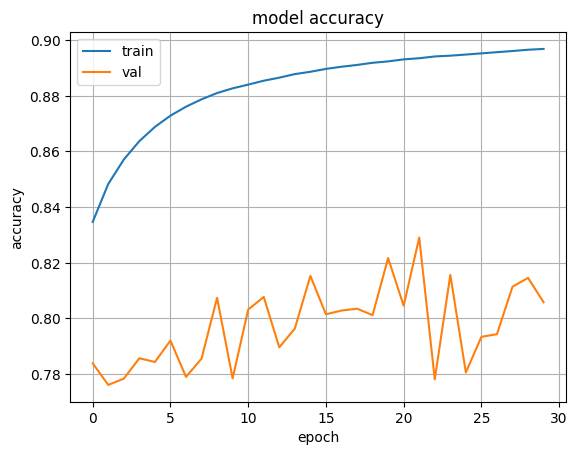

In [65]:
plt.plot(embedding_hist.history['accuracy'])
plt.plot(embedding_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

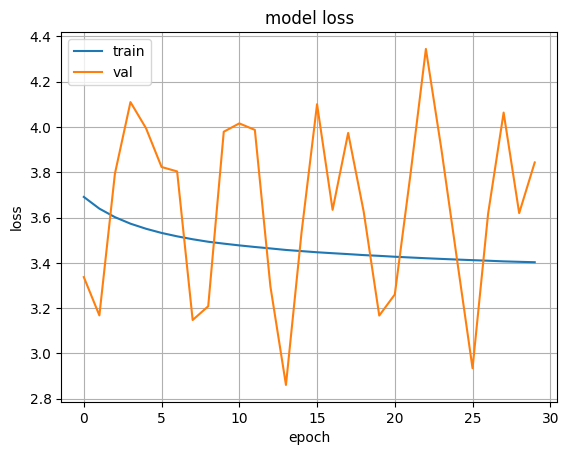

In [66]:
plt.plot(embedding_hist.history['loss'])
plt.plot(embedding_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [67]:
save_path = 'models/'
embedding_model.save_weights(save_path + 'embedding_network.h5')